In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import arrow
from scipy.signal import savgol_filter 
import numpy as np
from lmfit.models import SkewedGaussianModel

In [2]:
# data from: http://ncov.mohw.go.kr/
df = pd.read_csv("all.csv").loc[1:].reset_index()
df["counts"] = [float(c.replace(",", "")) for c in df["계(명)"]]
df["savgol"] = savgol_filter([float(c.replace(",", "")) for c in df["계(명)"]], 7, 2)
df["ts"] = pd.to_datetime([str(arrow.get(t)) for t in df["일자"]])
df["rolling_avg"] = df["counts"].rolling(7).mean()
df.tail()

,index,일자,계(명),계(명).1,해외유입(명),사망(명),counts,savgol,ts,rolling_avg
805,806,2022.4.5,"266,135","266,108",27,209,266135.0,227724.000000,2022-04-05 00:00:00+00:00,273922.000000
806,807,2022.4.6,"286,294","286,272",22,371,286294.0,243220.142857,2022-04-06 00:00:00+00:00,254158.142857
807,808,2022.4.7,"224,820","224,780",40,348,224820.0,235929.571429,2022-04-07 00:00:00+00:00,240454.857143
808,809,2022.4.8,"205,333","205,325",8,373,205333.0,216288.857143,2022-04-08 00:00:00+00:00,229749.142857
809,810,2022.4.9,"185,566","185,547",19,338,185566.0,184298.000000,2022-04-09 00:00:00+00:00,218519.857143


In [3]:
df["weekday"] = [t.weekday() for t in df.ts]
df["counts_vs_rolling_avg"] = (df['counts'] - df['rolling_avg']) / df['rolling_avg']

df_for_weekdaytype = df[780:809].reset_index()
weekday_filter_weights = []
for weeknum in range(7):
    dat = df_for_weekdaytype.loc[df_for_weekdaytype.weekday == weeknum].counts_vs_rolling_avg.to_numpy()
    weekday_filter_weights.append(np.median(dat))
    
weekday_filter_weights

[-0.45984489044417665,
 -0.010375245588724536,
 0.19402192202001067,
 0.03203274687910064,
 -0.051317705233094146,
 -0.0510811275159606,
 -0.12838768882025478]

In [4]:
def skewed_gaussian_fitting_n_plot(target_y, start_idx, df, show_stats=False, weighted=False, show_plots=True):
    """
    Parameters
    ----------
    target_y: univariate series to fit. 
    start_idx: start index
    df: whole dataframe
    show_stats: bool for plotting figs.
    weighted=False: bool for weighted fitting. If True, more recent data points get more weights on fitting. 
    
    """
    window_length = len(df) - start_idx
    april = pd.to_datetime([f"2022-04-{x}T00:00:00+00:00'" for x in range(1,31)]).to_list()
    may = pd.to_datetime([f"2022-05-{x}T00:00:00+00:00'" for x in range(1,32)]).to_list()
    whole_date = df["ts"].to_list() + april + may

    whole_date = sorted(list(set(whole_date)))
    xvals = np.arange(0, window_length)
    yvals = target_y[start_idx:]

    model = SkewedGaussianModel()

    # set initial parameter values
    params = model.make_params(amplitude=13639305., center=102.12, sigma=22.41, gamma=0)

    # adjust parameters  to best fit data.
    if weighted:
        result = model.fit(yvals, params, x=xvals, weights=xvals + 50)
    else:
        result = model.fit(yvals, params, x=xvals)
    
    if show_stats:
        print(result.fit_report())

    expected = result.eval(x=np.arange(-20, window_length+35))
    if show_plots:
        plt.figure(figsize=(6.5, 3))
        plt.title("fitting")
        plt.plot(xvals, yvals, 'd')
        ex = result.eval(x=xvals)
        plt.plot(xvals, ex)
        
        plt.figure(figsize=(8, 3))
        plt.plot(whole_date[start_idx-20:start_idx+window_length],  target_y[start_idx-20:], 'd', label="daily Covid cases")
        plt.plot(whole_date[start_idx-20:start_idx+window_length+35], expected, label="skewed gaussian fitting")
        plt.legend()
        plt.title("Forecasting Korean Covid cases")
        plt.xticks(whole_date[start_idx-20:start_idx+window_length+35][::15])
        
    return whole_date[start_idx-20:start_idx+window_length+35], target_y[start_idx-20:], expected


def weekday_filter(data, weeknum_series):
    filtered = []
    for data_single, weeknum in zip(data, weeknum_series):
        result = data_single * (weekday_filter_weights[weeknum]+1)
        filtered.append(result)
        
    return filtered
        
    

## 7-day rolling avg & original confirmed cases

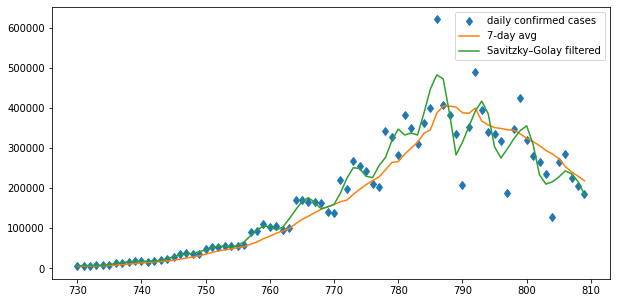

In [5]:
plt.figure(figsize=(10, 5))
plt.plot(df.counts[730:], 'd', label="daily confirmed cases")
df.rolling_avg[730:].plot(label="7-day avg")
df.savgol[730:].plot(label="Savitzky–Golay filtered")
plt.legend()

## skewed normal fifting using original data

[[Model]]
    Model(skewed_gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 140
    # data points      = 45
    # variables        = 4
    chi-square         = 1.9647e+11
    reduced chi-square = 4.7921e+09
    Akaike info crit   = 1006.87121
    Bayesian info crit = 1014.09786
[[Variables]]
    amplitude:  15331877.9 +/- 968204.401 (6.31%) (init = 1.363930e+07)
    center:     24.1165809 +/- 114020.270 (472787.87%) (init = 102.12)
    sigma:      16.0367835 +/- 953.436037 (5945.31%) (init = 22.41)
    gamma:     -0.01048470 +/- 8912.09578 (85000953.17%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(center, gamma)     = -1.000
    C(center, sigma)     = 1.000
    C(sigma, gamma)      = -1.000
    C(amplitude, gamma)  = 0.309
    C(amplitude, center) = -0.309
    C(amplitude, sigma)  = -0.308
next day(2022-04-10 00:00:00+00:00) prediction: 140838


Text(0.5, 1.0, 'Predicting Covid cases in Korea')

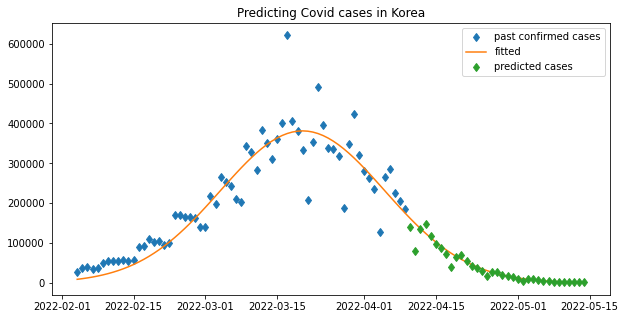

In [6]:
target_y = df.counts
start_idx = 765

x, y, y_expect = skewed_gaussian_fitting_n_plot(target_y, start_idx, df,
                                                show_stats=True,
                                                show_plots=False)

window_length = len(df) - start_idx
weekday_series = [t.weekday() for t in x]
filtered_data = weekday_filter(y_expect, weekday_series)

plt.figure(figsize=(10, 5))
plt.plot(x[:len(y)], y, 'd', label="past confirmed cases")
plt.plot(x, y_expect, label="fitted")
plt.plot(x[len(y):], filtered_data[len(y):], 'd', label='predicted cases')
plt.legend()
print(f"next day({x[len(y)]}) prediction:", int(filtered_data[len(y)]))
plt.title("Predicting Covid cases in Korea")

[[Model]]
    Model(skewed_gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 219
    # data points      = 45
    # variables        = 4
    chi-square         = 1.1003e+15
    reduced chi-square = 2.6837e+13
    Akaike info crit   = 1395.24747
    Bayesian info crit = 1402.47412
[[Variables]]
    amplitude:  15709908.6 +/- 1187316.57 (7.56%) (init = 1.363930e+07)
    center:     10.2212261 +/- 4.57107056 (44.72%) (init = 102.12)
    sigma:      23.4905415 +/- 6.81145297 (29.00%) (init = 22.41)
    gamma:      1.75317623 +/- 1.45339293 (82.90%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(center, sigma)     = -0.975
    C(sigma, gamma)      = 0.955
    C(center, gamma)     = -0.949
    C(amplitude, sigma)  = 0.695
    C(amplitude, center) = -0.664
    C(amplitude, gamma)  = 0.504
next day(2022-04-10 00:00:00+00:00) prediction: 154703


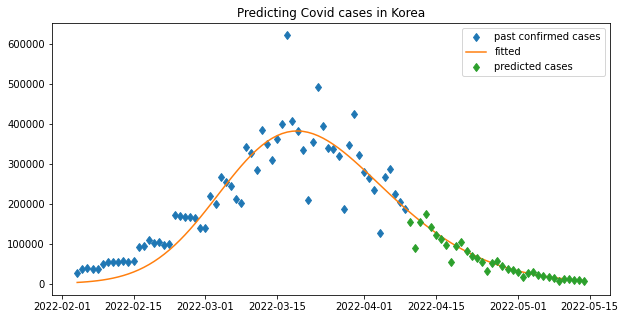

In [7]:
target_y = df.counts
start_idx = 765

x, y, y_expect = skewed_gaussian_fitting_n_plot(target_y, start_idx, df,
                                                show_stats=True,
                                                show_plots=False,
                                                weighted=True)

window_length = len(df) - start_idx
weekday_series = [t.weekday() for t in x]
filtered_data = weekday_filter(y_expect, weekday_series)

plt.figure(figsize=(10, 5))
plt.plot(x[:len(y)], y, 'd', label="past confirmed cases")
plt.plot(x, y_expect, label="fitted")
plt.plot(x[len(y):], filtered_data[len(y):], 'd', label='predicted cases')
plt.legend()
print(f"next day({x[len(y)]}) prediction:", int(filtered_data[len(y)]))
plt.title("Predicting Covid cases in Korea")
plt.savefig("figs/fitting_n_prediction.png", facecolor="w")

## skewed normal fifting using 7-day rolling avg

[[Model]]
    Model(skewed_gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 99
    # data points      = 45
    # variables        = 4
    chi-square         = 1.1659e+10
    reduced chi-square = 2.8437e+08
    Akaike info crit   = 879.771389
    Bayesian info crit = 886.998038
[[Variables]]
    amplitude:  15160407.5 +/- 242658.476 (1.60%) (init = 1.363930e+07)
    center:     37.8000812 +/- 2.00312767 (5.30%) (init = 102.12)
    sigma:      20.2510035 +/- 1.75461942 (8.66%) (init = 22.41)
    gamma:     -1.17054684 +/- 0.38943228 (33.27%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(center, sigma)     = 0.989
    C(center, gamma)     = -0.984
    C(sigma, gamma)      = -0.973
    C(amplitude, gamma)  = 0.273
    C(amplitude, center) = -0.152


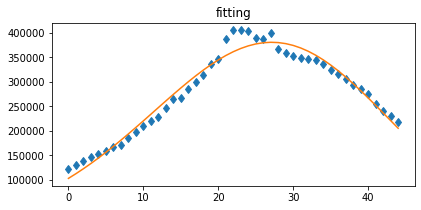

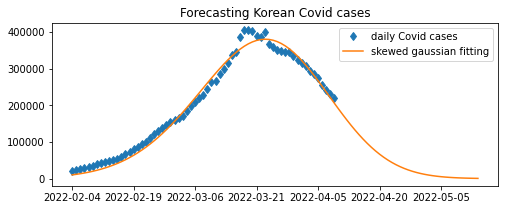

In [8]:
target_y = df.rolling_avg
start_idx = 765

skewed_gaussian_fitting_n_plot(target_y, start_idx, df, show_stats=True)
plt.show()

[[Model]]
    Model(skewed_gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 133
    # data points      = 45
    # variables        = 4
    chi-square         = 5.7090e+13
    reduced chi-square = 1.3924e+12
    Akaike info crit   = 1262.10450
    Bayesian info crit = 1269.33115
[[Variables]]
    amplitude:  15196807.1 +/- 236600.480 (1.56%) (init = 1.363930e+07)
    center:     33.2433799 +/- 9.80345223 (29.49%) (init = 102.12)
    sigma:      17.3753147 +/- 4.21224827 (24.24%) (init = 22.41)
    gamma:     -0.55915674 +/- 0.98322598 (175.84%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(center, gamma)     = -1.000
    C(center, sigma)     = 0.997
    C(sigma, gamma)      = -0.997
    C(amplitude, gamma)  = 0.197
    C(amplitude, center) = -0.186
    C(amplitude, sigma)  = -0.128


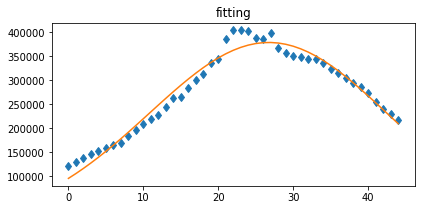

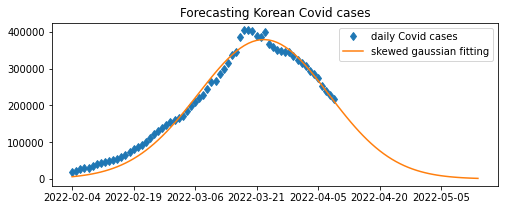

In [9]:
target_y = df.rolling_avg
start_idx = 765

skewed_gaussian_fitting_n_plot(target_y, start_idx, df, show_stats=True, weighted=True)
plt.show()

## skewed normal fifting using Savitzky–Golay filtered signal

[[Model]]
    Model(skewed_gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 136
    # data points      = 45
    # variables        = 4
    chi-square         = 7.8060e+10
    reduced chi-square = 1.9039e+09
    Akaike info crit   = 965.333924
    Bayesian info crit = 972.560574
[[Variables]]
    amplitude:  15317418.8 +/- 605357.516 (3.95%) (init = 1.363930e+07)
    center:     23.6747356 +/- 46406.0287 (196014.98%) (init = 102.12)
    sigma:      16.0234395 +/- 486.548047 (3036.48%) (init = 22.41)
    gamma:      0.02160190 +/- 3630.79199 (16807745.77%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(center, gamma)     = -1.000
    C(sigma, gamma)      = 1.000
    C(center, sigma)     = -1.000
    C(amplitude, sigma)  = 0.292
    C(amplitude, gamma)  = 0.291
    C(amplitude, center) = -0.291


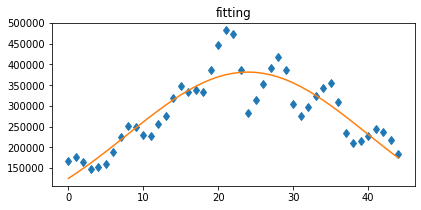

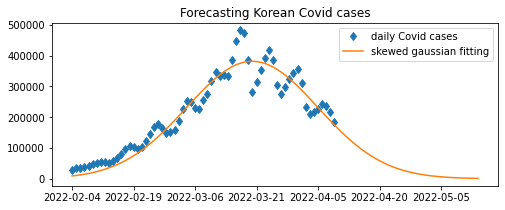

In [10]:
target_y = df.savgol
start_idx = 765

skewed_gaussian_fitting_n_plot(target_y, start_idx, df, show_stats=True)
plt.show()


[[Model]]
    Model(skewed_gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 232
    # data points      = 45
    # variables        = 4
    chi-square         = 4.1758e+14
    reduced chi-square = 1.0185e+13
    Akaike info crit   = 1351.64762
    Bayesian info crit = 1358.87427
[[Variables]]
    amplitude:  15670663.1 +/- 725089.767 (4.63%) (init = 1.363930e+07)
    center:     10.3279994 +/- 2.91543769 (28.23%) (init = 102.12)
    sigma:      23.2757536 +/- 4.23587749 (18.20%) (init = 22.41)
    gamma:      1.71422614 +/- 0.89775342 (52.37%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(center, sigma)     = -0.976
    C(sigma, gamma)      = 0.957
    C(center, gamma)     = -0.953
    C(amplitude, sigma)  = 0.687
    C(amplitude, center) = -0.654
    C(amplitude, gamma)  = 0.498


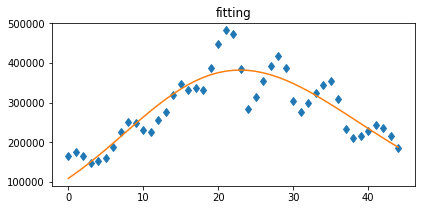

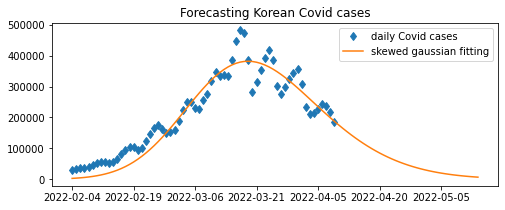

In [11]:
target_y = df.savgol
start_idx = 765

skewed_gaussian_fitting_n_plot(target_y, start_idx, df, show_stats=True, weighted=True)
plt.show()